In [223]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [10]:
X, y = sklearn.datasets.load_digits(return_X_y=True)

In [12]:
dt = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=5)
rf = RandomForestClassifier(n_estimators=20, random_state=42)

In [15]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [19]:
scores = cross_val_score(dt, X, y, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.5s finished


In [21]:
scores.mean(), scores.std()

(0.7707149489322191, 0.03374332121073383)

In [224]:
X_norm = X / 16

In [587]:
n_comp = 16
seed = 42
# A = W @ H
# A.shape = m x n
# W.shape = m x n_comp
# H.shape = n_comp x n
n, m = X.shape
np.random.seed(seed)
W = np.abs(np.random.normal(size=(n, n_comp))) * 0.01
H = np.abs(np.random.normal(size=(n_comp, m))) * 0.01

In [588]:
assert X.shape == (W @ H).shape

In [589]:
lr = .001  # learning rate
lmd = 1000 # penalty for negative terms

In [590]:
mu = 1e-6

def penalty(M):
    return np.where(M >= 0, 0,  np.min(M - mu, 0))

def penalty_grad(M):
    return np.where(M >= 0, 0, np.min(M - mu, 0))

In [591]:
def grads(A, W, H):
    WH = W @ H
    R = WH - A  # Residual
    dW = R @ H.T
    dH = W.T @ R
    return dW, dH

In [592]:
def error(A, W, H):
    s = np.linalg.norm(A - W @ H) + penalty(W).sum() + penalty(H).sum()
    W_neg = (W < 0).sum()
    H_neg = (H < 0).sum()
    return s, W_neg, H_neg

In [593]:
error(X_norm, W, H)

(164.0412754451145, 0, 0)

In [594]:
def update(A, W, H):
    dW, dH = grads(A, W, H)
    dW_pen = penalty_grad(W) * lmd
    dH_pen = penalty_grad(H) * lmd
    return W - lr * (dW + dW_pen), H - lr * (dH + dH_pen)

In [595]:
W_new, H_new = update(X_norm, W, H)
error(X_norm, W_new, H_new)

(163.82730062852897, 0, 0)

In [596]:
for i in range(10000):
    if i % 1000 == 0:
        print(error(X_norm, W, H))
    W, H = update(X_norm, W, H)

(164.0412754451145, 0, 0)
(35.62903738443076, 3000, 356)
(35.11982570195434, 2637, 377)
(35.1179388202772, 2463, 387)
(35.23981955707871, 2476, 376)
(34.98103842246284, 2441, 381)
(34.950454872456234, 2360, 382)
(35.00839536410102, 2351, 381)
(35.085171270353534, 2363, 381)
(34.70639354168823, 2419, 404)


In [597]:
W_pos = np.where(W >= 0, W, -W)
H_pos = np.where(H >= 0, H, -H)
error(X_norm, W_pos, H_pos)

(42.65152119237285, 0, 0)

In [598]:
np.linalg.norm(X - (W_pos @ H_pos)*16)

682.4243390779656

In [599]:
scores = cross_val_score(dt, W_pos, y, cv=cv, n_jobs=-1, verbose=1, scoring='accuracy')
scores.mean(), scores.std()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


(0.7757505416279791, 0.021688106807947905)

In [600]:
X_restored = (W_pos @ H_pos) * 16

In [608]:
def plot(im1, im2):
    f, ax = plt.subplots(ncols=2)
    ax[0].imshow(im1.reshape((8, 8)))
    ax[1].imshow(im2.reshape((8, 8)));   

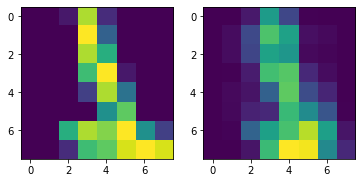

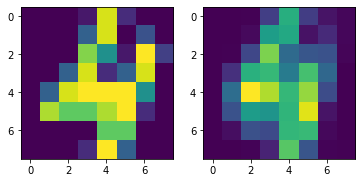

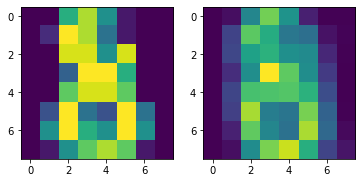

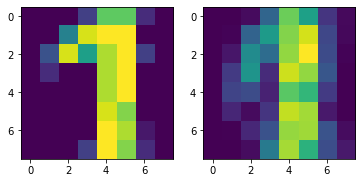

In [612]:
for i in [1000, 1001, -1, 1500]:
    plot(X[i], X_restored[i])
    plt.show()

In [615]:
# W - X projected onto subspace H
# H - subspace of columns of X
X.shape, W.shape, H.shape

((1797, 64), (1797, 16), (16, 64))